In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, MetaData
import sqlalchemy
from sqlalchemy import Integer, String, Float
from sqlalchemy import Column,Integer,Sequence, String, Boolean
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import psycopg2
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import seaborn
import scipy.stats as stats
import pylab as pl
import folium
from IPython.display import HTML


In [3]:

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [43]:
result = pd.read_excel('/Users/ryan/Desktop/may12_portaldata.xlsx', encoding= 'utf-8-sig')

result['hh_size_hhinfo'] = pd.to_numeric(result['hh_size_hhinfo'], errors='coerce')

result.loc[result['incomplete'] == 0, 'complete'] = 1
result.loc[result['refusal'] == 1, 'complete'] = 0
result.loc[result['perm_unavail'] == 1, 'complete'] = 0

In [61]:
counts = result[['state_name','dist_name','refusal','incomplete','complete', 'perm_unavail']].groupby(['state_name','dist_name']).sum()
counts['attempted'] = result[['state_name','dist_name','dod_enumerator_id_intro']].groupby(['state_name','dist_name']).count()
def highlight_max(data, color='green'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def highlight_min(data, color='red'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns) 

def highlight_max_back(data, color='red'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def highlight_min_back(data, color='green'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns) 

counts['total'] = counts.sum(axis=1)


counts.style.\
    apply(highlight_min, subset=['complete', 'attempted','total']).\
    apply(highlight_max, subset=['complete', 'attempted','total']).\
    apply(highlight_min_back, subset=['refusal', 'incomplete','perm_unavail']).\
    apply(highlight_max_back, subset=['refusal', 'incomplete','perm_unavail'])


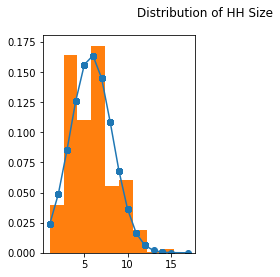

In [7]:
h = sorted(result['hh_size_hhinfo'].dropna())  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.hist(h,normed=True)
pl.suptitle("Distribution of HH Size")
pl.show()  



In [45]:
#x = np.linspace(0, 2 * np.pi, 400)
#y = np.sin(x ** 2)

#pl.close('all')


#f, (ax1, ax2) = pl.subplots(1, 2, sharey=True)
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)


In [46]:
a = result.gps_location_end.str.split(' ').dropna()
b = pd.DataFrame((item for item in a), columns = ['lat','long','alt','acc'])
b['lat'] = pd.to_numeric(b['lat'], errors='coerce')
b['long'] = pd.to_numeric(b['long'], errors='coerce')
b['ref'] = result['refusal']
b['comp'] = result['incomplete']

In [48]:
lat = b['lat'].values
lon = b['long'].values
colors = {1 : 'red', 0 : 'blue'}


map_osm = folium.Map(location=[26.222534, 82],zoom_start=6)
b.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=1,color=colors[row['comp']])
                                             .add_to(map_osm), axis=1)


iframe = map_osm._repr_html_()
display(HTML(iframe))
